# Data Analysis

This notebook contains code for plots and tables used in the paper, as well as further analysis that could not be fitted into the paper.

## Import Packages and Data

In [28]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from utils import *


csv_files = glob.glob('RawStudyData/timestamps/csv/*.csv')

# Concatenate all CSV files into a single dataframe
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

df['Total Number of Changes'] = df['Number of Changes to Model'] + df['Number of Changes to Inference']
df['Total Percent of Time spend in Inference'] = df['Inference Count'] * df['Mean Inference Time'] / df['Total Task Time']

df

,name,Task,order,Inference Count,Cancelled Inference Count,Mean Inference Time,Median Inference Time,Setup Issue Count,Total Setup Issue Duration,Removed Event Count,...,Fully Solved (seconds),Total Task Time,First Issue Detected,First Issue Solved,Second Issue Detected,Second Issue Solved,Third Issue Detected,Third Issue Solved,Total Number of Changes,Total Percent of Time spend in Inference
0,Rimouski,A,1,2,0,69.76,69.76,0,0.00,0,...,584.626,919.36,NaN,585.0,NaN,NaN,NaN,NaN,2,0.151758
1,Rimouski,C,2,5,1,127.51,118.67,1,79.64,0,...,575.515,1795.37,48.0,195.0,161.0,217.0,NaN,576.0,4,0.355108
2,Rimouski,B,3,4,2,251.00,268.89,2,255.75,0,...,NaN,1751.51,292.0,169.0,NaN,330.0,NaN,NaN,5,0.573220
3,Montreal,A,1,4,1,60.70,57.80,1,33.39,0,...,985.366,1763.29,NaN,985.0,NaN,NaN,NaN,NaN,5,0.137697
4,Montreal,B,2,3,1,139.93,147.53,0,0.00,0,...,NaN,796.12,524.0,528.0,539.0,778.0,NaN,NaN,2,0.527295
5,Montreal,C,3,8,6,183.46,197.81,0,0.00,0,...,NaN,1958.24,406.0,421.0,463.0,679.0,664.0,NaN,4,0.749489
6,Burnaby,C,1,2,1,218.22,218.22,0,0.00,0,...,NaN,1884.59,NaN,NaN,NaN,NaN,NaN,NaN,1,0.231584
7,Burnaby,B,2,6,1,200.52,216.92,1,201.56,0,...,1479.351,1833.28,85.0,109.0,304.0,432.0,1376.0,1479.0,5,0.656266
8,Burnaby,A,3,5,0,164.33,102.97,0,0.00,0,...,279.703,1446.64,186.0,280.0,NaN,NaN,NaN,NaN,7,0.567971
9,Nelson,A,1,2,0,92.74,92.74,1,101.72,0,...,1321.828,1396.19,1079.0,1322.0,NaN,NaN,NaN,NaN,1,0.132847


## Test Normality

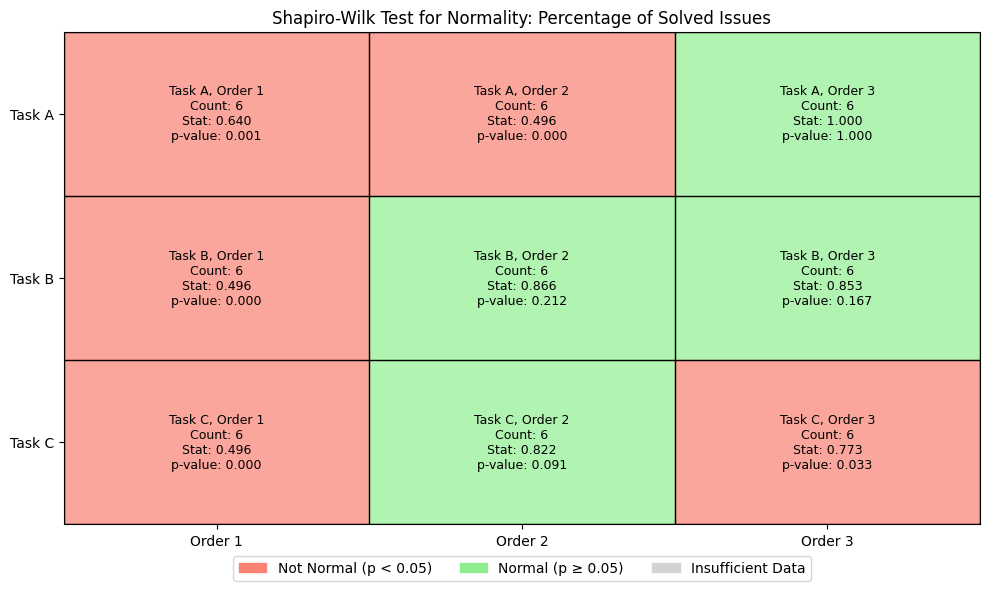

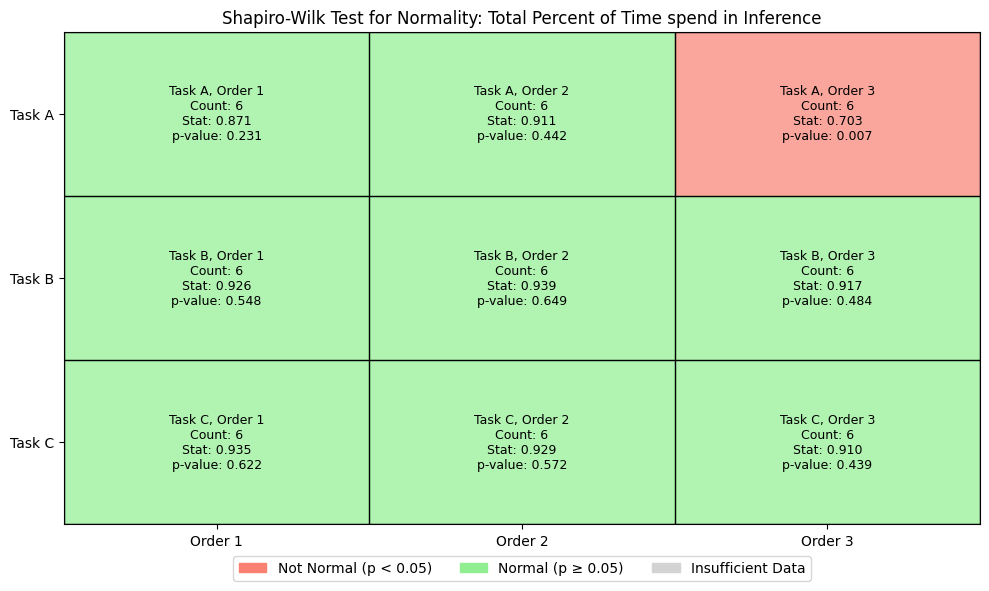

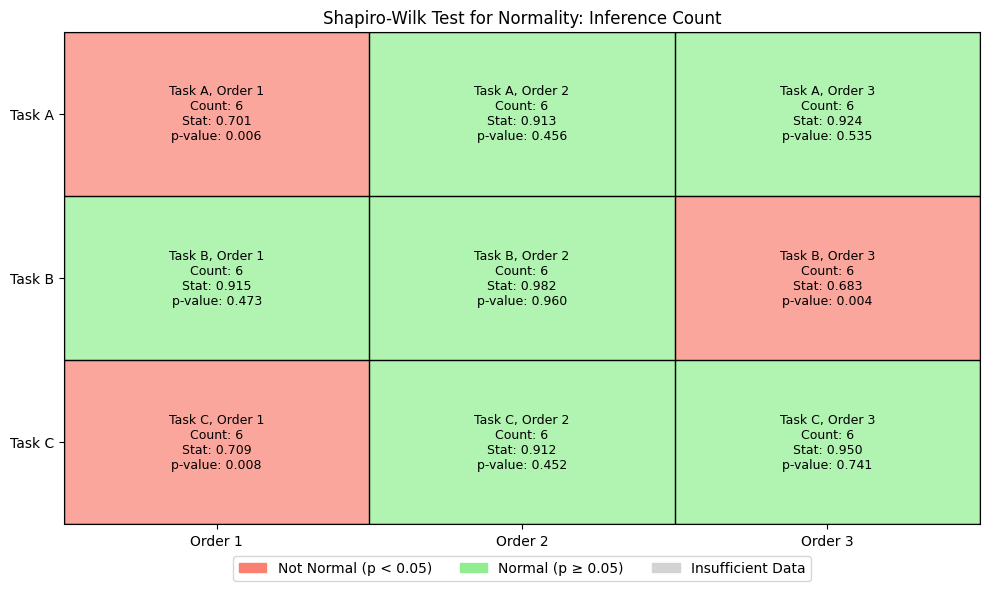

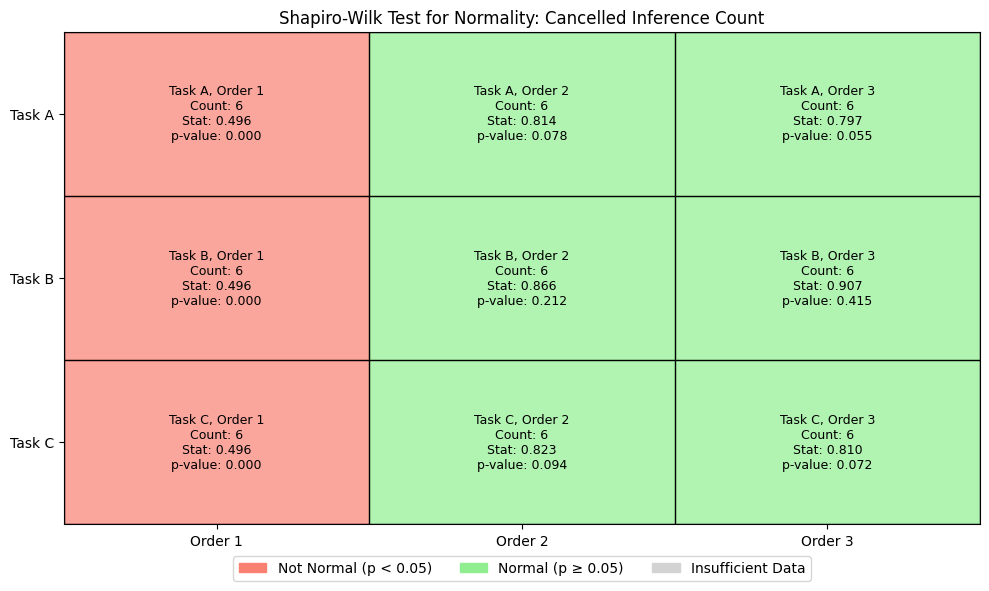

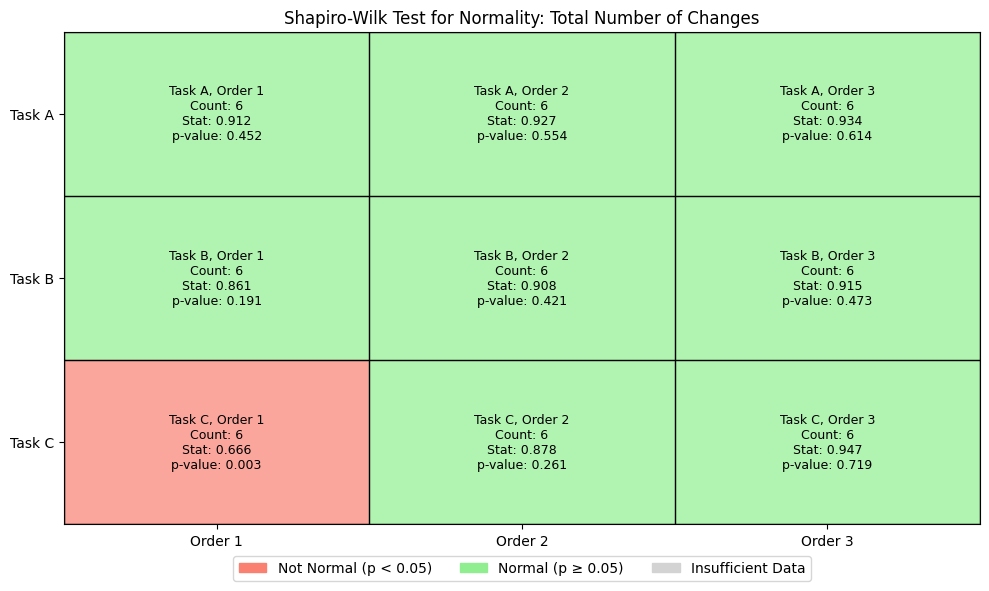

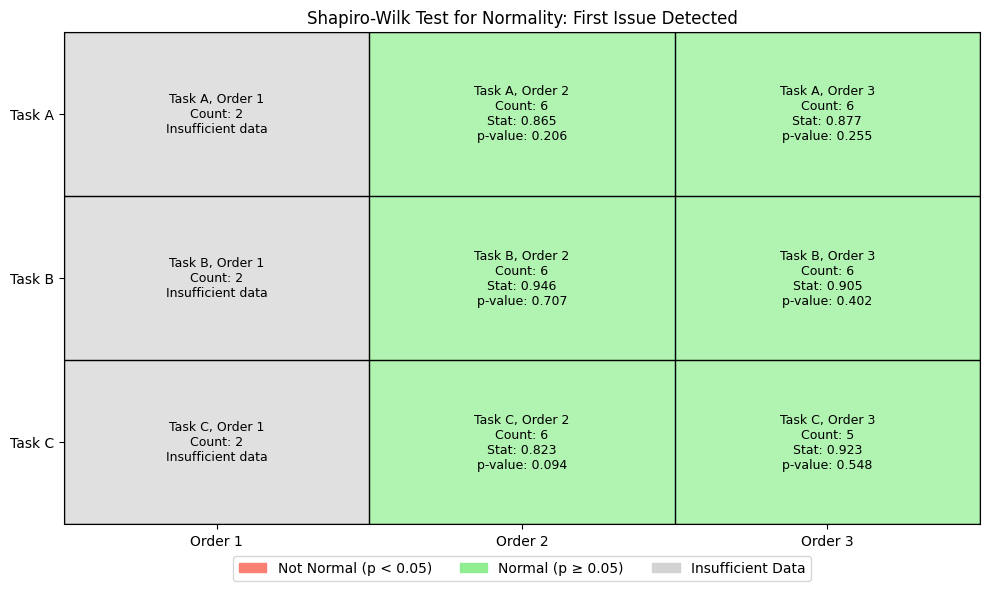

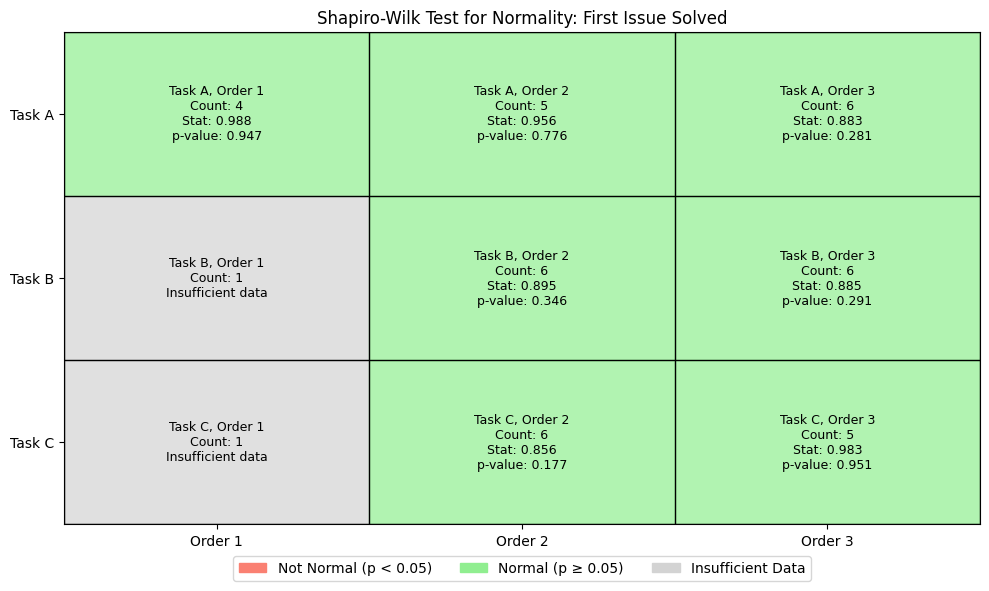

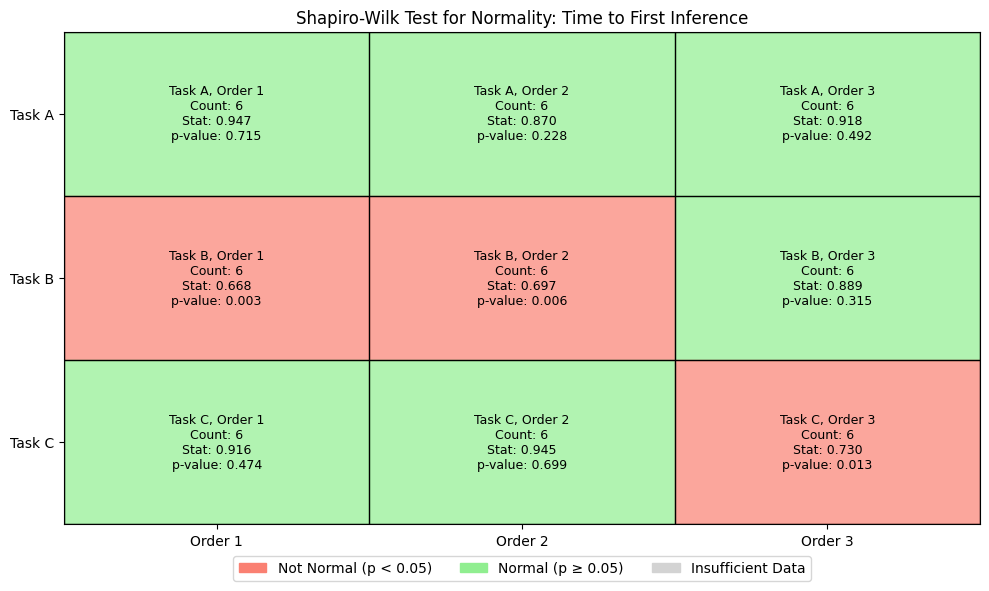

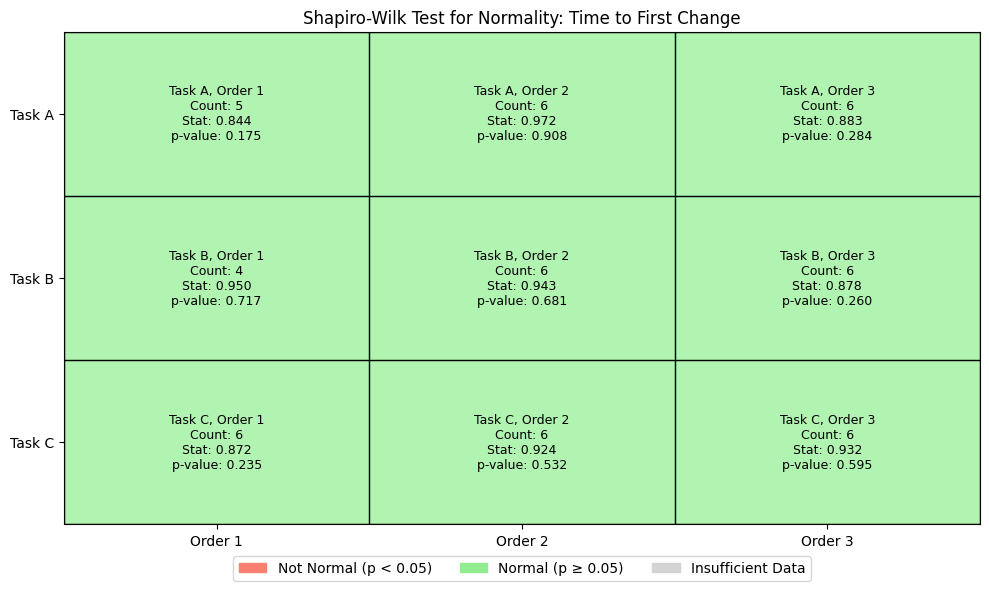

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Shapiro-Wilk Test for Normality: Time to First Change'}>)

In [29]:
plot_shapiro_test_matrix(df, 'Percentage of Solved Issues')
plot_shapiro_test_matrix(df, 'Total Percent of Time spend in Inference')
plot_shapiro_test_matrix(df, 'Inference Count')
plot_shapiro_test_matrix(df, 'Cancelled Inference Count')
plot_shapiro_test_matrix(df, 'Total Number of Changes')
plot_shapiro_test_matrix(df, 'First Issue Detected')
plot_shapiro_test_matrix(df, 'First Issue Solved')
plot_shapiro_test_matrix(df, 'Time to First Inference')
plot_shapiro_test_matrix(df, 'Time to First Change')

## RQ1 - Quantitative Tests

In [30]:
def default_quant_tests(df, test, percent_scale=True, replace_zeros=False, remove_nan=True, add_nan_counts=False, add_p_values=True, alpha=0.05):
    create_beautiful_boxplot(df, test, percent_scale=percent_scale, replace_zeros=False, remove_nan=True, add_nan_counts=False, add_p_values=True)
    plt.show()
    
    results = []
    replace_zeros = test in ['First Issue Detected', 'First Issue Solved']
    res_pooled = perform_test_and_save_latex(df, test, alpha=0.05, replace_zeros=False, alternative='two-sided', pooled=True)
    res_seperate = perform_test_and_save_latex(df, test, alpha=0.05, replace_zeros=False, alternative='two-sided', pooled=False)
    results.append((test, res_pooled, res_seperate))
    display_styled_results_tables(results, alpha=0.05)

### H1 - PPL users are able to resolve more issues with the tool

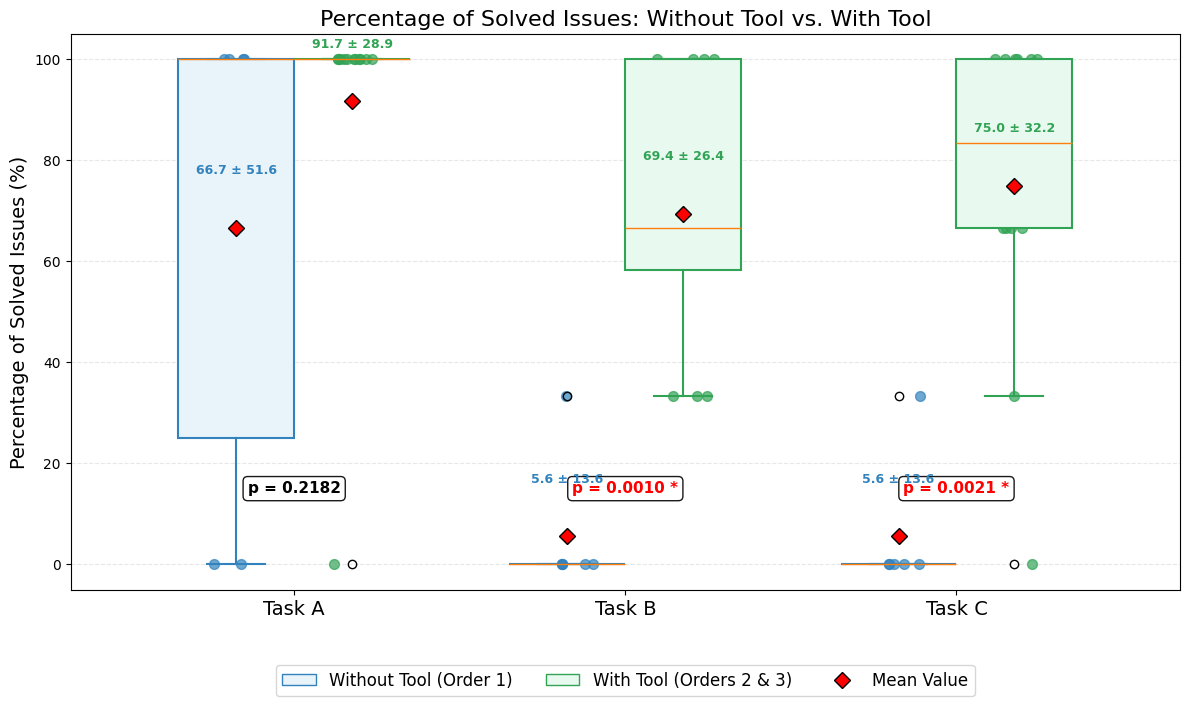

,Task,W/,W/O,Cliff's δ,p-value
0,A,91.67 ± 28.87,66.67 ± 51.64,0.250000,0.2182
1,B,69.45 ± 26.43,5.55 ± 13.61,0.958333,0.0010
2,C,75.00 ± 32.18,5.55 ± 13.61,0.888889,0.0021


,Task,1,2,3,1vs2 p-value,1vs3 p-value,2vs3 p-value
0,A,66.67 ± 51.64,83.33 ± 40.82,100.00 ± 0.00,0.5948,0.1739,0.4047
1,B,5.55 ± 13.61,72.22 ± 25.09,66.67 ± 29.82,0.0043,0.0056,0.7980
2,C,5.55 ± 13.61,77.78 ± 27.22,72.22 ± 38.97,0.0043,0.0156,1.0000


In [31]:
default_quant_tests(df, 'Percentage of Solved Issues', percent_scale=True, replace_zeros=False, remove_nan=True, add_nan_counts=False, add_p_values=True)

### H2 - PPL users are able to identify issues faster with the tool

In [32]:
column_of_interest = 'First Issue Detected'

df_survival = df.copy()
df_survival['tool'] = df_survival['order'].apply(lambda x: 0 if x == 1 else 1)
df_survival['event'] = df_survival[column_of_interest].notna().astype(int)
df_survival['time'] = df_survival[column_of_interest].replace(0, np.nan)
df_survival['time'] = df_survival[column_of_interest].replace(0.0, np.nan)

print(df_survival['time'].isna().sum())

df_survival['time'] = df_survival['time'].fillna(df_survival['Total Task Time'])

df_survival = df_survival[['name', 'Task', 'tool', 'event', 'time']]
df_survival

13


,name,Task,tool,event,time
0,Rimouski,A,0,0,919.36
1,Rimouski,C,1,1,48.00
2,Rimouski,B,1,1,292.00
3,Montreal,A,0,0,1763.29
4,Montreal,B,1,1,524.00
5,Montreal,C,1,1,406.00
6,Burnaby,C,0,0,1884.59
7,Burnaby,B,1,1,85.00
8,Burnaby,A,1,1,186.00
9,Nelson,A,0,1,1079.00


13
180    0.000000
300    0.055556
Name: Total Density at 180s and 300s, dtype: float64
180    0.333333
300    0.833333
Name: Total Density at 180s and 300s, dtype: float64


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.96 <0.005      9.29

Task A Test statistic: 9.957945467887393, p-value: 0.0016015668360302663


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.18 <0.005     11.79

Task B Test statistic: 13.177764154598213, p-value: 0.0002832905525874248


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.42 <0.005     10.43

Task C Test statistic: 11.420701902108355, p-value: 0.000726302512121833


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.97 <0.005     30.38

All tasks pooled Test statistic: 37.97387382744698, p-value: 7.169833461345902e-10


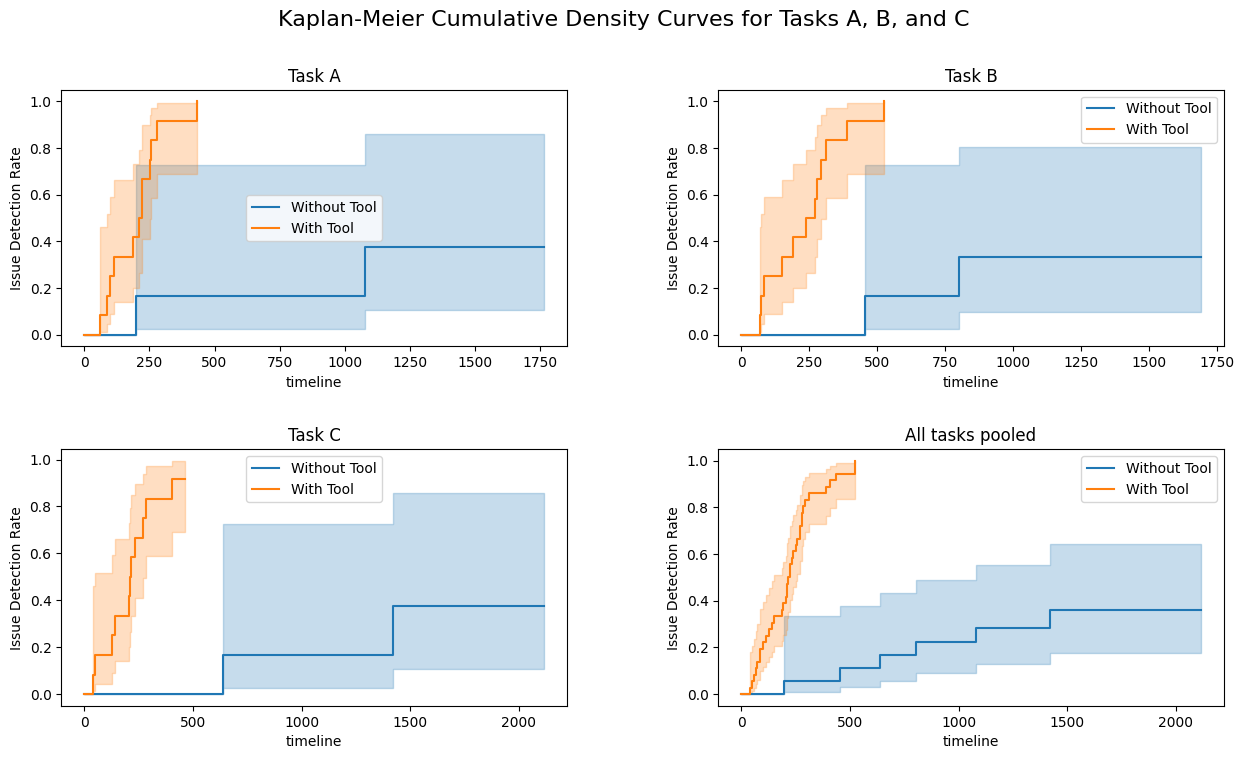



Task A


<lifelines.CoxPHFitter: fitted with 18 total observations, 4 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 18
number of events observed = 14
   partial log-likelihood = -28.17
         time fit was run = 2025-07-17 13:46:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       1.96      7.13      0.73            0.54            3.39                1.71               29.74

           cmp to    z    p  -log2(p)
covariate                            
tool         0.00 2.69 0.01      7.15
---
Concordance = 0.70
Partial AIC = 58.33
log-likelihood ratio test = 9.65 on 1 df
-log2(p) of ll-ratio test = 9.05



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


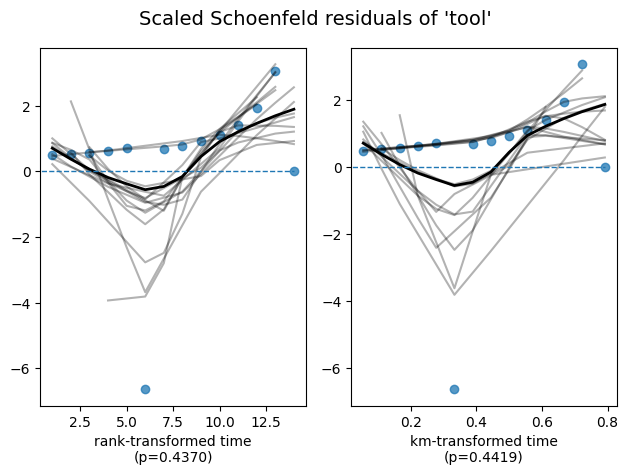



Task B


<lifelines.CoxPHFitter: fitted with 18 total observations, 4 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 18
number of events observed = 14
   partial log-likelihood = -27.06
         time fit was run = 2025-07-17 13:46:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       2.21      9.11      0.72            0.79            3.63                2.21               37.61

           cmp to    z      p  -log2(p)
covariate                              
tool         0.00 3.06 <0.005      8.80
---
Concordance = 0.74
Partial AIC = 56.12
log-likelihood ratio test = 12.31 on 1 df
-log2(p) of ll-ratio test = 11.12



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


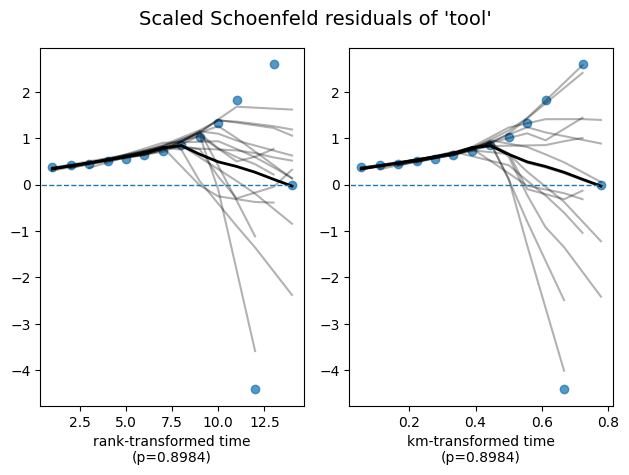



Task C


<lifelines.CoxPHFitter: fitted with 18 total observations, 5 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 18
number of events observed = 13
   partial log-likelihood = -25.46
         time fit was run = 2025-07-17 13:46:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       2.39     10.92      0.87            0.68            4.10                1.98               60.33

           cmp to    z    p  -log2(p)
covariate                            
tool         0.00 2.74 0.01      7.35
---
Concordance = 0.74
Partial AIC = 52.91
log-likelihood ratio test = 11.19 on 1 df
-log2(p) of ll-ratio test = 10.24



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


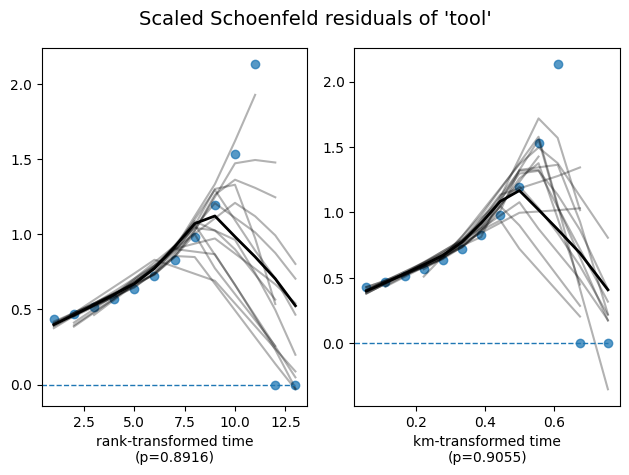



All Tasks pooled


<lifelines.CoxPHFitter: fitted with 54 total observations, 13 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 54
number of events observed = 41
   partial log-likelihood = -118.04
         time fit was run = 2025-07-17 13:46:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       3.41     30.35      0.76            1.93            4.90                6.86              134.20

           cmp to    z      p  -log2(p)
covariate                              
tool         0.00 4.50 <0.005     17.17
---
Concordance = 0.72
Partial AIC = 238.07
log-likelihood ratio test = 45.93 on 1 df
-log2(p) of ll-ratio test = 36.25



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


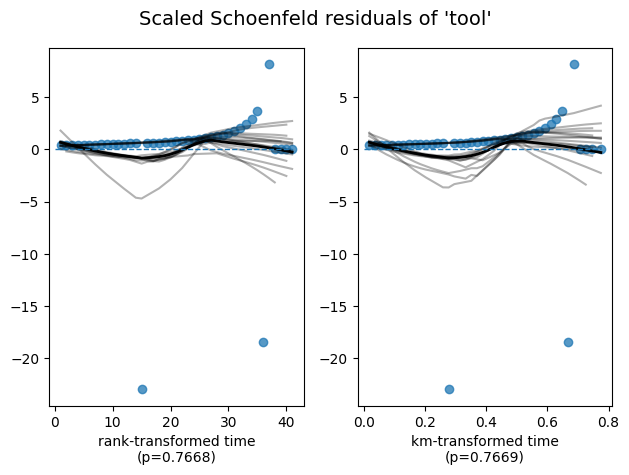

In [33]:
survival_analysis_results = survival_analysis(df, column_of_interest, nan_fill_value=df['Total Task Time'], replace_zeros=True, yAxis='Issue Detection Rate')

### H3 - PPL users have faster iteration cycles with the tool

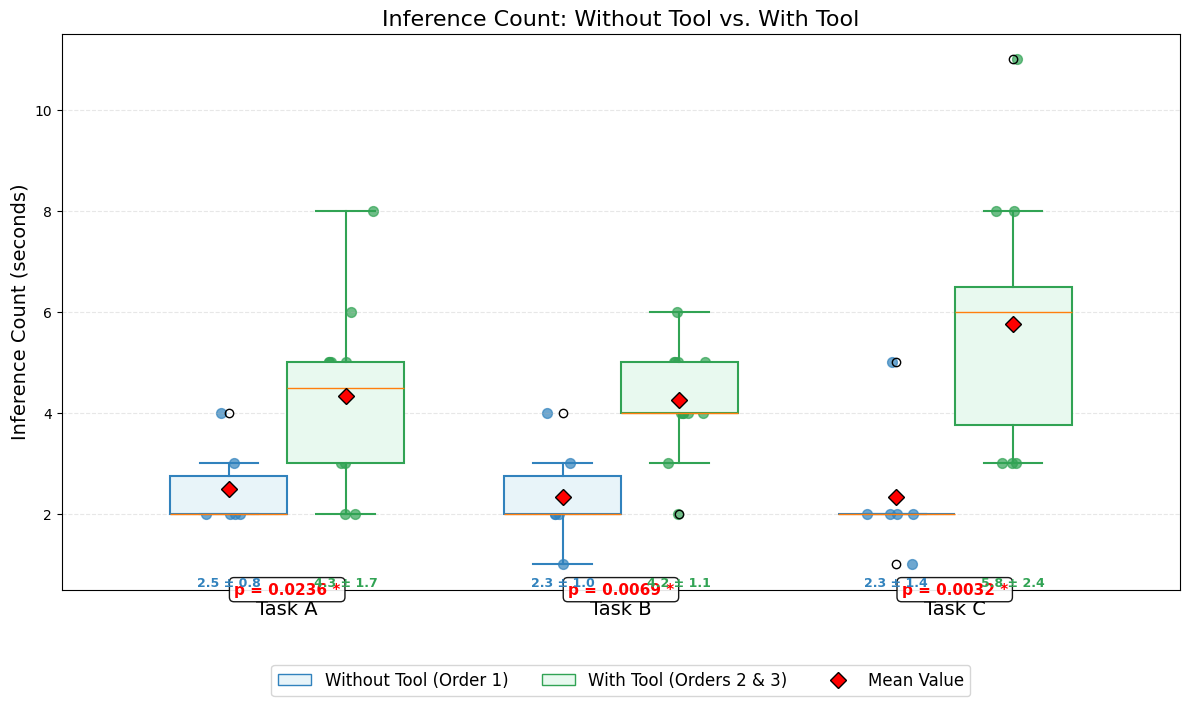

,Task,W/,W/O,Cliff's δ,p-value
0,A,4.33 ± 1.72,2.50 ± 0.84,0.666667,0.0236
1,B,4.25 ± 1.06,2.33 ± 1.03,0.791667,0.0069
2,C,5.75 ± 2.42,2.33 ± 1.37,0.875000,0.0032


,Task,1,2,3,1vs2 p-value,1vs3 p-value,2vs3 p-value
0,A,2.50 ± 0.84,4.00 ± 1.55,4.67 ± 1.97,0.0784,0.0361,0.7431
1,B,2.33 ± 1.03,4.00 ± 1.41,4.50 ± 0.55,0.0585,0.0081,0.4984
2,C,2.33 ± 1.37,5.17 ± 1.94,6.33 ± 2.88,0.0140,0.0114,0.5105


In [34]:
default_quant_tests(df, 'Inference Count', percent_scale=False, replace_zeros=False, remove_nan=True, add_nan_counts=False, add_p_values=True)

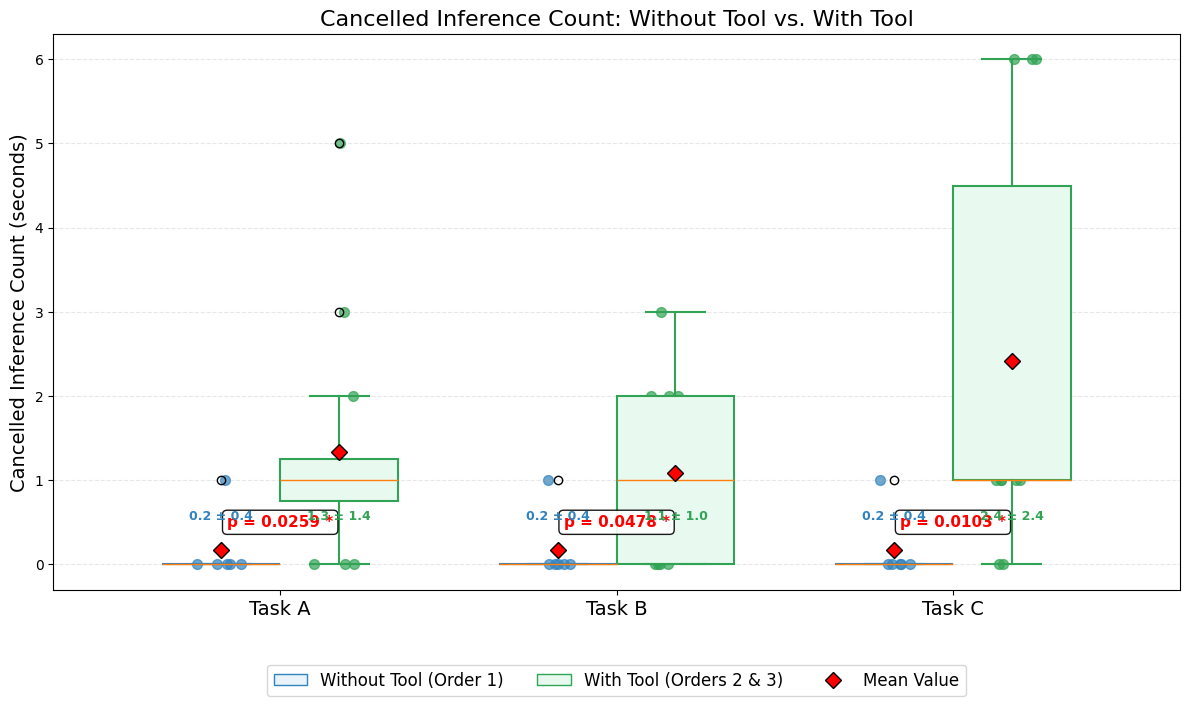

,Task,W/,W/O,Cliff's δ,p-value
0,A,1.33 ± 1.44,0.17 ± 0.41,0.625000,0.0259
1,B,1.08 ± 1.00,0.17 ± 0.41,0.555556,0.0478
2,C,2.42 ± 2.39,0.17 ± 0.41,0.736111,0.0103


,Task,1,2,3,1vs2 p-value,1vs3 p-value,2vs3 p-value
0,A,0.17 ± 0.41,1.00 ± 1.10,1.67 ± 1.75,0.1003,0.0292,0.4907
1,B,0.17 ± 0.41,0.83 ± 0.75,1.33 ± 1.21,0.1003,0.0729,0.5034
2,C,0.17 ± 0.41,2.17 ± 2.32,2.67 ± 2.66,0.0292,0.0248,0.7374


In [35]:
default_quant_tests(df, 'Cancelled Inference Count', percent_scale=False, replace_zeros=False, remove_nan=True, add_nan_counts=False, add_p_values=True)

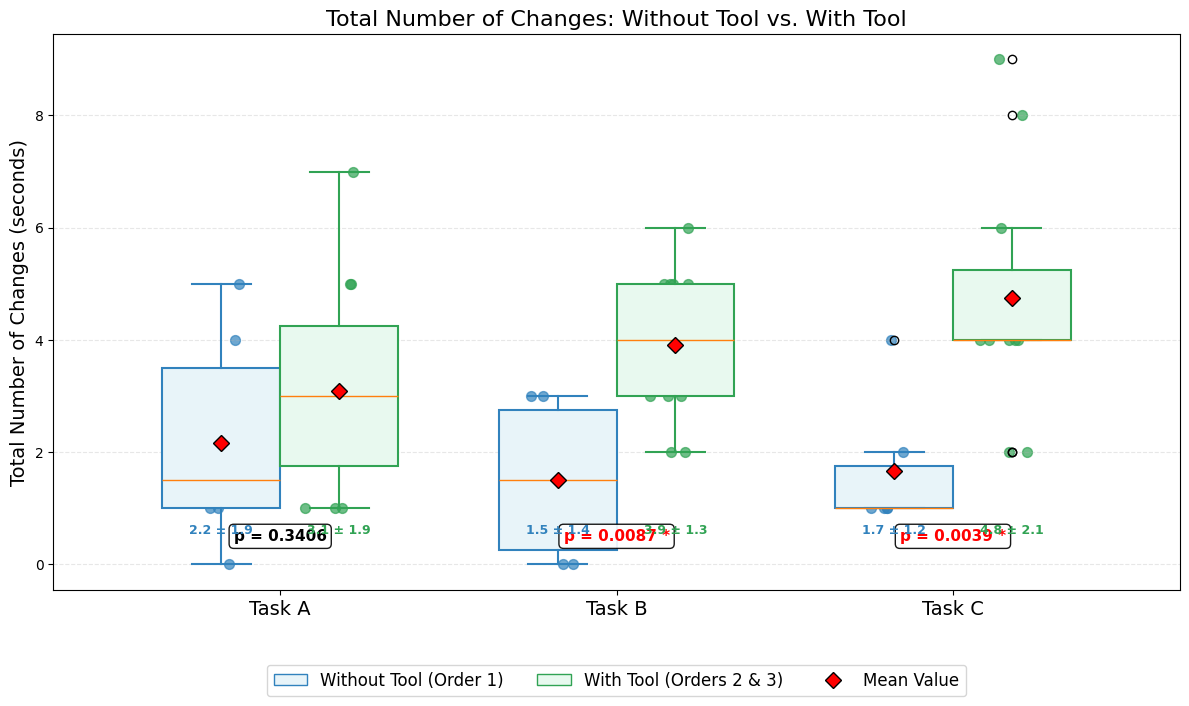

,Task,W/,W/O,Cliff's δ,p-value
0,A,3.08 ± 1.88,2.17 ± 1.94,0.291667,0.3406
1,B,3.92 ± 1.31,1.50 ± 1.38,0.777778,0.0087
2,C,4.75 ± 2.09,1.67 ± 1.21,0.847222,0.0039


,Task,1,2,3,1vs2 p-value,1vs3 p-value,2vs3 p-value
0,A,2.17 ± 1.94,2.67 ± 1.37,3.50 ± 2.35,0.5144,0.3682,0.6248
1,B,1.50 ± 1.38,3.17 ± 1.17,4.67 ± 1.03,0.0841,0.0073,0.0581
2,C,1.67 ± 1.21,4.50 ± 1.97,5.00 ± 2.37,0.0159,0.0136,0.6769


In [36]:
default_quant_tests(df, 'Total Number of Changes', percent_scale=False, replace_zeros=False, remove_nan=True, add_nan_counts=False, add_p_values=True)

### H4 - PPL users spend their time more effectively with the tool

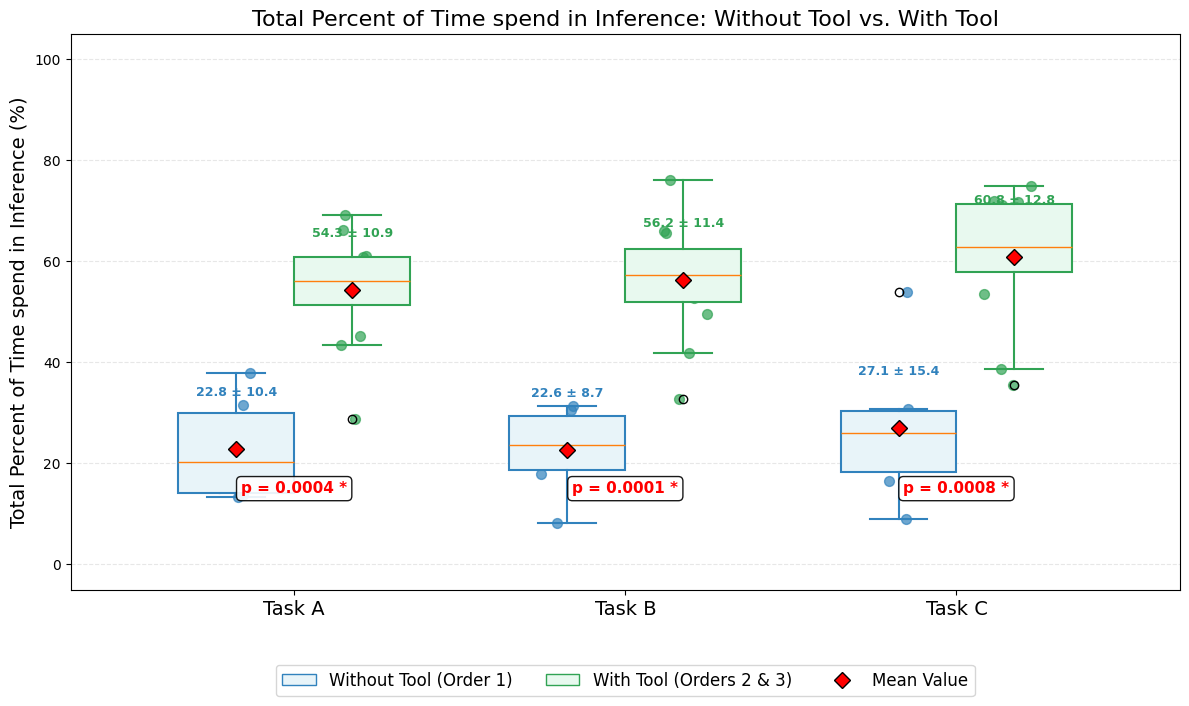

,Task,W/,W/O,Cliff's δ,p-value
0,A,54.31 ± 10.94,22.83 ± 10.38,0.944444,0.0004
1,B,56.25 ± 11.44,22.57 ± 8.73,1.000000,0.0001
2,C,60.76 ± 12.75,27.06 ± 15.45,0.916667,0.0008


,Task,1,2,3,1vs2 p-value,1vs3 p-value,2vs3 p-value
0,A,22.83 ± 10.38,56.92 ± 10.66,51.69 ± 11.54,0.0022,0.0087,0.3939
1,B,22.57 ± 8.73,55.53 ± 9.43,56.97 ± 14.06,0.0022,0.0022,0.6991
2,C,27.06 ± 15.45,54.34 ± 14.82,67.17 ± 6.27,0.0152,0.0022,0.1320


In [37]:
t_df = df.copy()
t_df['Total Percent of Time spend in Inference'] = t_df['Total Percent of Time spend in Inference'] * 100

default_quant_tests(t_df, 'Total Percent of Time spend in Inference', percent_scale=True)

## Quantitative Analysis

In [38]:
df_qual = pd.read_csv('RawStudyData/Inference Analysis Post-Study Survey.csv')

df_qual

,Zeitstempel,Participant ID,I think I was able to solve...,I found Task 1,I found Task 2,I found Task 3,Anything you want to tell us about the tasks?,The tool provides a good selection of visualizations,I was missing certain visualizations (please let us know in the area below which ones you would find useful),The visualizations during inference time helped me detect issues earlier,...,Task 1 would have been easier with access to the presented tool,Task 2 would have been harder without access to the tool.,Task 3 would have been harder without access to the tool.,I would have been able to solve,I would use the presented tool in the future,Anything you want to tell us about the tool in general?,I learned new things using the tool,The tool showed me visualizations I have never seen before,The tool deepened my understanding of Bayesian inference,Anything else you want to tell us?
0,2025/02/24 11:43:19 AM OEZ,montreal,Task 1;Task 2,2,3,7,NaN,6,4,6,...,6,6,6,Task 1 with the tool,6,NaN,6,7,5,NaN
1,2025/02/25 12:51:25 PM OEZ,inuvik,Task 2;Task 3,7,4,5,"Task 1 was a ""complete different setup"" than t...",7,1,5,...,5,6,7,Task 2 without the tool,7,"nice work, inituitive usage and stable connect...",7,4,4,NaN
2,2025/02/25 4:12:34 PM OEZ,quebec,Task 2,7,2,5,"I'm not sure if my task 3 is solved, although ...",5,6,5,...,7,7,7,Task 1 with the tool,6,It is useful to me.,6,4,5,It is a good tool for education too.
3,2025/02/25 7:22:29 PM OEZ,miramichi,Task 1;Task 3,2,3,6,Maybe providing the background about the data ...,7,7,7,...,6,7,7,Task 1 with the tool,7,NaN,7,5,4,NaN
4,2025/02/28 5:47:56 PM OEZ,Moosonee,Task 3,7,5,2,NaN,7,6,6,...,7,7,7,Task 1 with the tool,6,NaN,5,5,5,NaN
5,2025/03/04 11:25:23 AM OEZ,Dawson,Task 2;Task 3,5,2,2,/,7,2,7,...,7,6,3,Task 1 with the tool;Task 3 without the tool,7,NaN,3,4,3,NaN
6,2025/03/04 2:19:11 PM OEZ,gatineau,Task 2;Task 3,6,3,3,NaN,6,1,5,...,7,7,7,Task 1 with the tool,6,NaN,6,7,6,NaN
7,2025/03/04 5:36:19 PM OEZ,Lachine,Task 2;Task 3,7,2,3,NaN,7,2,5,...,7,6,6,Task 3 without the tool,6,NaN,5,4,3,NaN
8,2025/03/04 9:21:08 PM OEZ,Scarborough,Task 2;Task 3,5,2,3,Love the new debugger!!,7,2,6,...,6,7,7,None of the tasks,7,NaN,7,6,4,NaN
9,2025/03/05 4:30:58 PM OEZ,Kitimat,Task 1;Task 2;Task 3,2,4,4,No,5,4,6,...,1,6,6,Task 1 with the tool;Task 3 without the tool,6,NaN,6,6,5,NaN


In [39]:
import warnings
warnings.filterwarnings("ignore")

colors = [
    '#2166AC',  # Deep Blue (Strongly Disagree)
    '#4393C3',  # Medium Blue (Disagree)
    '#92C5DE',  # Light Blue (Somewhat Disagree)
    '#F7F7F7',  # Very Light Grey/Off-White (Neutral)
    '#A6D96A',  # Light Green/Lime (Somewhat Agree)
    '#66BD63',  # Medium Green (Agree)
    '#1A9641'   # Deep Sea Green (Strongly Agree)
]

### RQ2 - Are online visualizations of MCMC posteriors considered useful by PPL users?

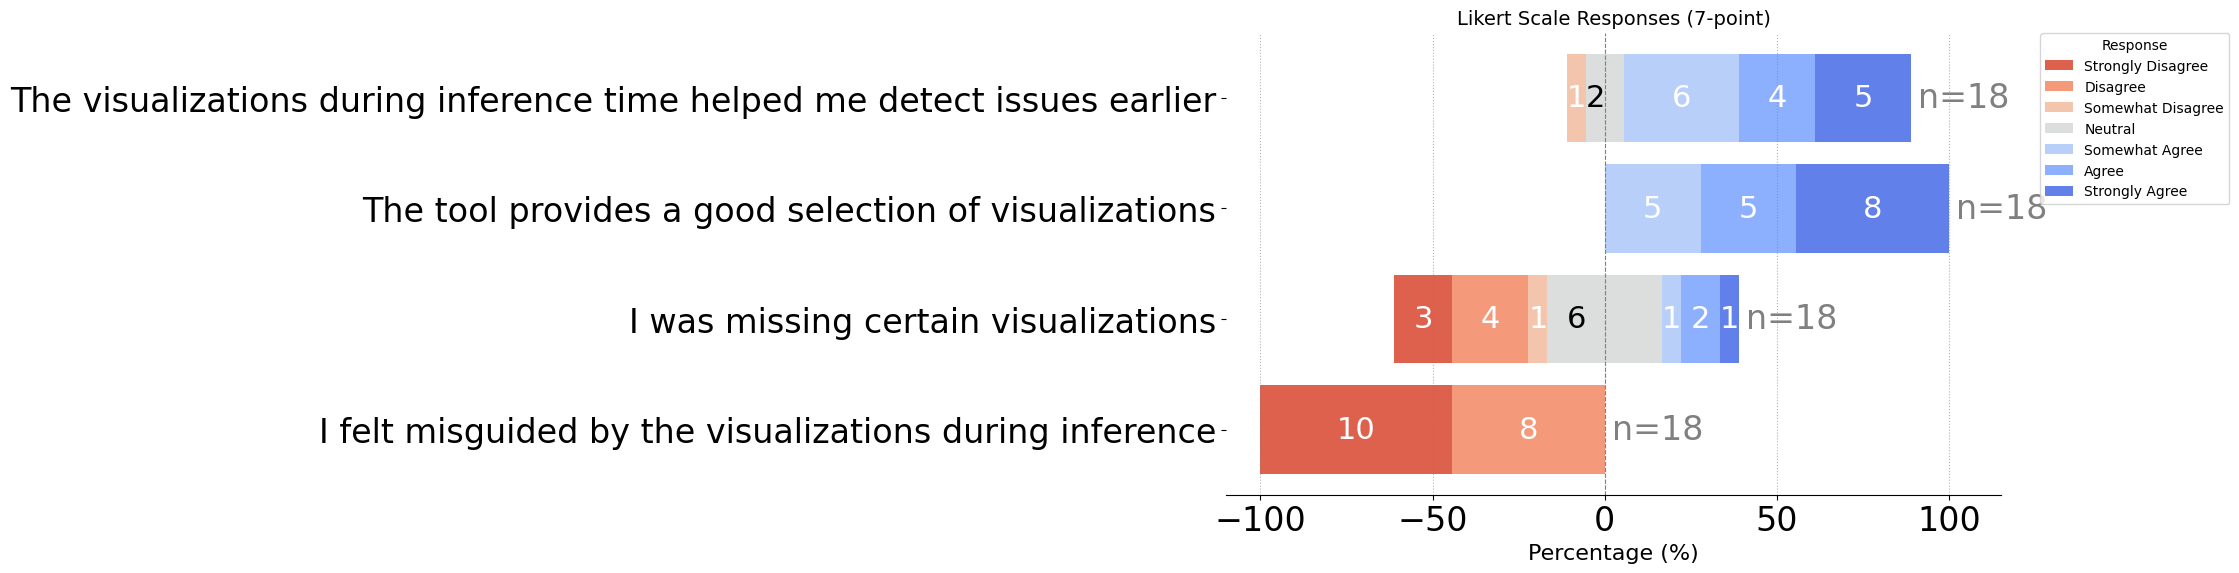

In [40]:
columns = [
	'The visualizations during inference time helped me detect issues earlier',
	'The tool provides a good selection of visualizations',
	'I was missing certain visualizations (please let us know in the area below which ones you would find useful)',
	'I felt misguided by the visualizations during inference'
]
tick_labels = [
	'The visualizations during inference time helped me detect issues earlier',
	'The tool provides a good selection of visualizations',
	'I was missing certain visualizations',
	'I felt misguided by the visualizations during inference'
]

plot_likert_scale(df_qual, columns, tick_labels=tick_labels, axis_label_fontsize=16, tick_label_fontsize=24);

### RQ3 - Are the warnings raised at inference time considered useful by PPL users?

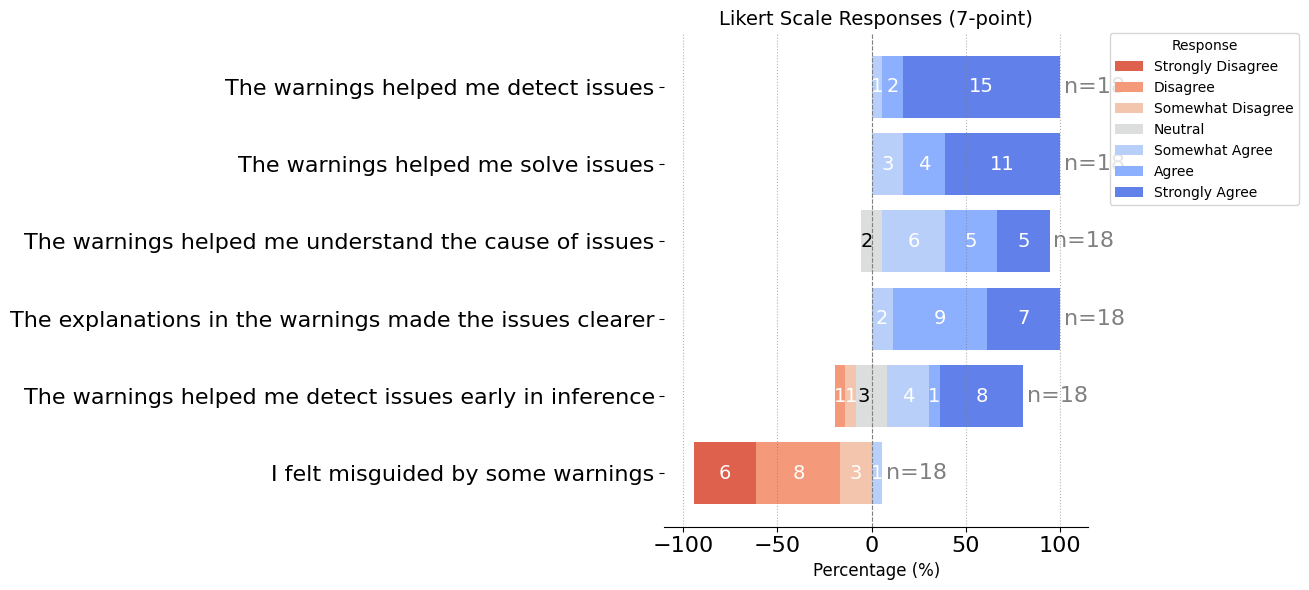

In [41]:
columns = [
	'The warnings helped me detect issues',
	'The warnings helped me solve issues',
	'The warnings helped me understand the cause of issues',
	'The explanations in the warnings made the issues clearer',
	'The warnings helped me detect issues early in inference',
	'I felt misguided by some warnings'
]
plot_likert_scale(df_qual, columns, axis_label_fontsize=12, figure_size=(16, 6), tick_label_fontsize=16);

## Some further insights

### Time to first change

3
180    0.000000
300    0.055556
Name: Total Density at 180s and 300s, dtype: float64
180    0.333333
300    0.666667
Name: Total Density at 180s and 300s, dtype: float64


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.55 <0.005      8.17

Task A Test statistic: 8.547375630801637, p-value: 0.0034602072235967434


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.18 <0.005     11.79

Task B Test statistic: 13.177764154598213, p-value: 0.0002832905525874248


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          14.63 <0.005     12.90

Task C Test statistic: 14.625668600549568, p-value: 0.0001311164523703285


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.69 <0.005     30.17

All tasks pooled Test statistic: 37.69142908960332, p-value: 8.286786579853274e-10


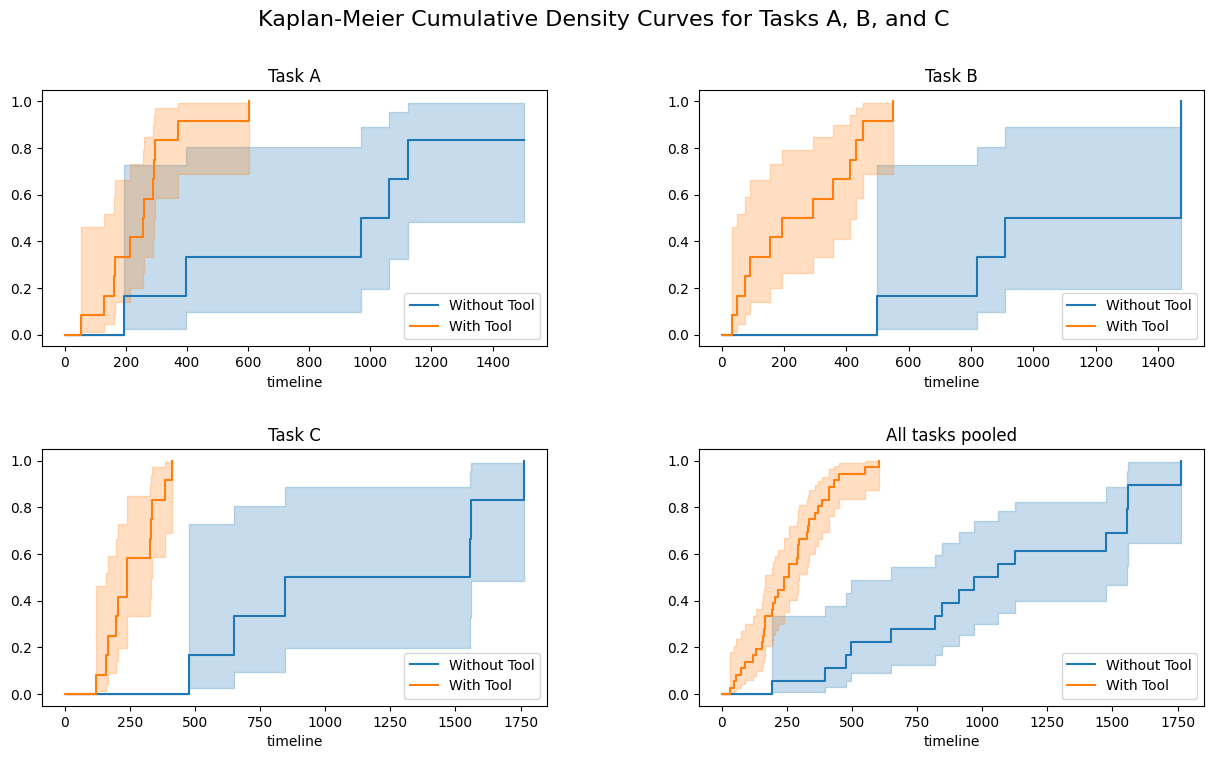



Task A


<lifelines.CoxPHFitter: fitted with 18 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 18
number of events observed = 17
   partial log-likelihood = -32.37
         time fit was run = 2025-07-17 13:46:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       1.67      5.29      0.65            0.40            2.93                1.49               18.81

           cmp to    z    p  -log2(p)
covariate                            
tool         0.00 2.57 0.01      6.63
---
Concordance = 0.68
Partial AIC = 66.74
log-likelihood ratio test = 8.05 on 1 df
-log2(p) of ll-ratio test = 7.78



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


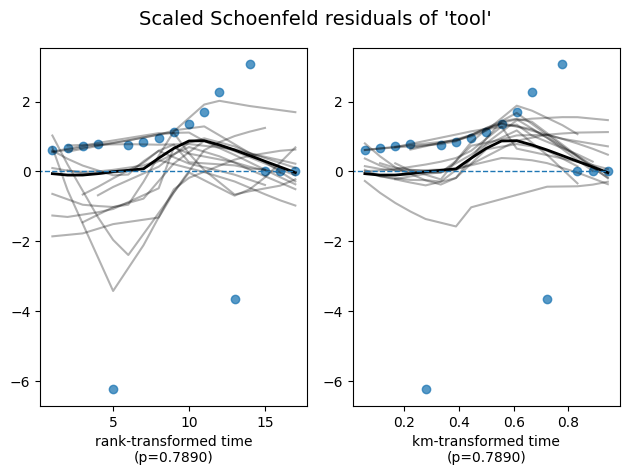



Task B


<lifelines.CoxPHFitter: fitted with 18 total observations, 2 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 18
number of events observed = 16
   partial log-likelihood = -28.45
         time fit was run = 2025-07-17 13:46:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       2.21      9.11      0.72            0.79            3.63                2.21               37.61

           cmp to    z      p  -log2(p)
covariate                              
tool         0.00 3.06 <0.005      8.80
---
Concordance = 0.73
Partial AIC = 58.90
log-likelihood ratio test = 12.31 on 1 df
-log2(p) of ll-ratio test = 11.12



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


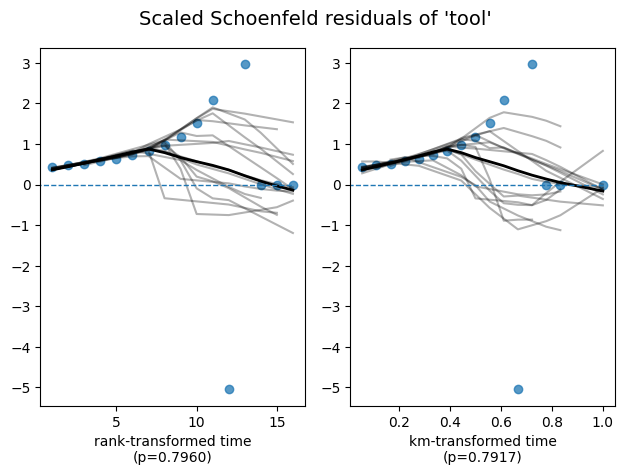



Task C


<lifelines.CoxPHFitter: fitted with 18 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 18
number of events observed = 18
   partial log-likelihood = -29.25
         time fit was run = 2025-07-17 13:46:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       2.63     13.93      0.85            0.96            4.31                2.61               74.39

           cmp to    z      p  -log2(p)
covariate                              
tool         0.00 3.08 <0.005      8.92
---
Concordance = 0.74
Partial AIC = 60.50
log-likelihood ratio test = 14.29 on 1 df
-log2(p) of ll-ratio test = 12.64



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


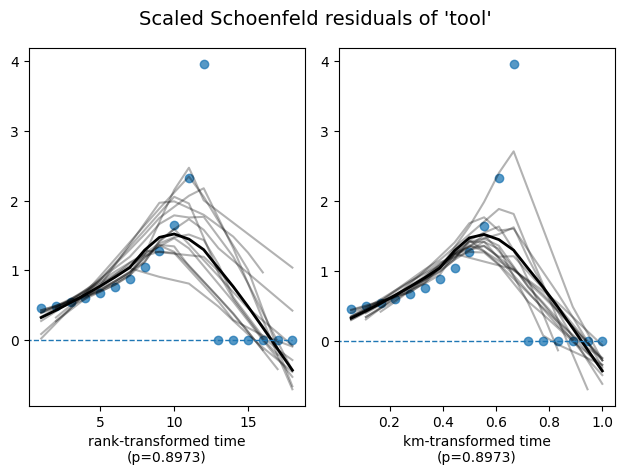



All Tasks pooled


<lifelines.CoxPHFitter: fitted with 54 total observations, 3 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 54
number of events observed = 51
   partial log-likelihood = -137.86
         time fit was run = 2025-07-17 13:46:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tool       2.80     16.52      0.56            1.71            3.90                5.54               49.27

           cmp to    z      p  -log2(p)
covariate                              
tool         0.00 5.03 <0.005     20.96
---
Concordance = 0.70
Partial AIC = 277.72
log-likelihood ratio test = 42.67 on 1 df
-log2(p) of ll-ratio test = 33.85



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


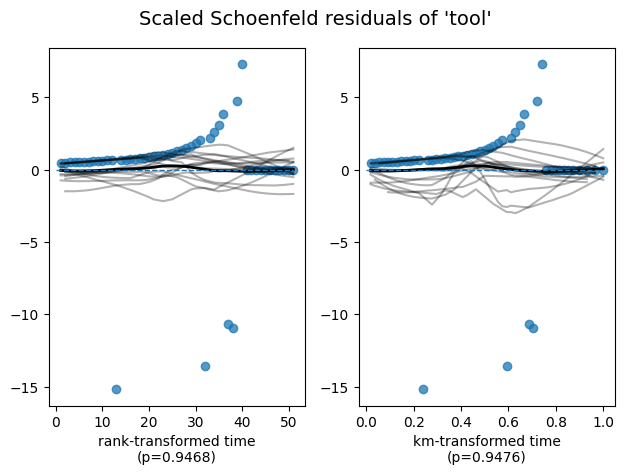

In [42]:
survival_analysis_results = survival_analysis(df, 'Time to First Change', nan_fill_value=df['Total Task Time'], replace_zeros=True)

### Some data insight plots

In [43]:
def group_tasks_order_and_plot(df, column, title, ylabel, xlabel):
	# Group by 'Task' and calculate the mean solving times
	group_by_column = df.groupby(['Task', 'order'])[column].mean().unstack()

	# Display the result
	group_by_column.plot(kind='bar', title=title)
	plt.ylabel(ylabel)
	plt.xlabel(xlabel)
	plt.show()
	
def group_tasks_order_and_fillna_and_plot(df, column, fill, title, ylabel, xlabel):
	# Fill NaN values in the specified column
	df2 = df.copy()
	df2[column] = df2[column].replace(0.000, np.nan)
	df2[column] = df2[column].fillna(fill)
	
	# Group by 'Task' and 'order' and calculate the mean
	group_by_column = df2.groupby(['Task', 'order'])[column].mean().unstack()

	# Display the result
	group_by_column.plot(kind='bar', title=title)
	plt.ylabel(ylabel)
	plt.xlabel(xlabel)
	plt.show()
	


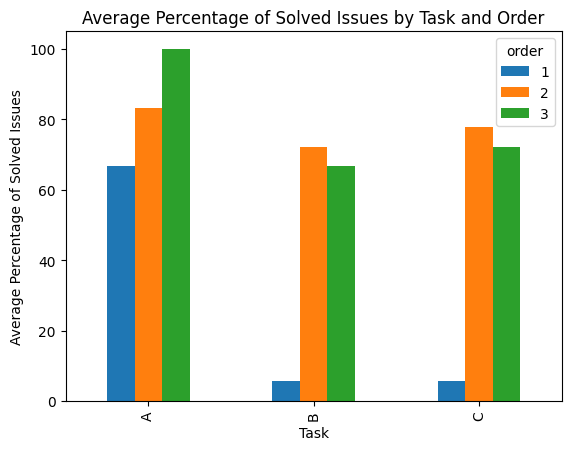

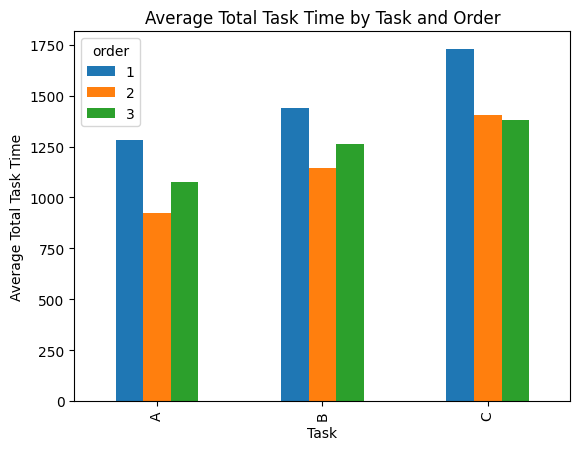

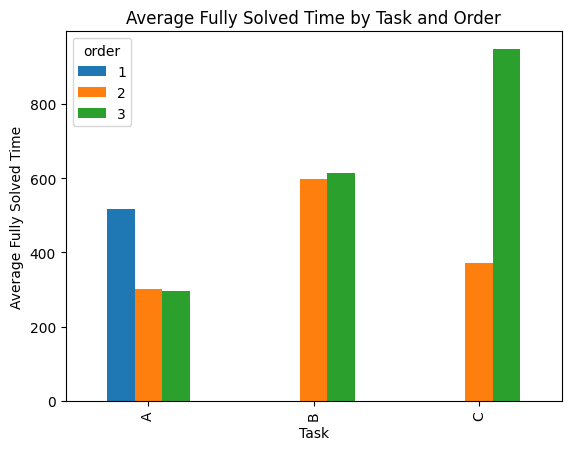

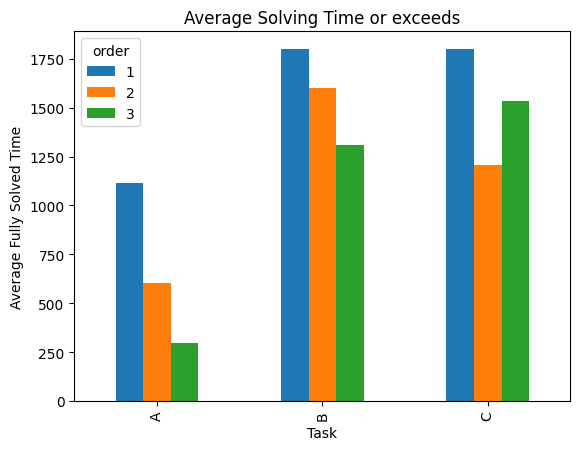

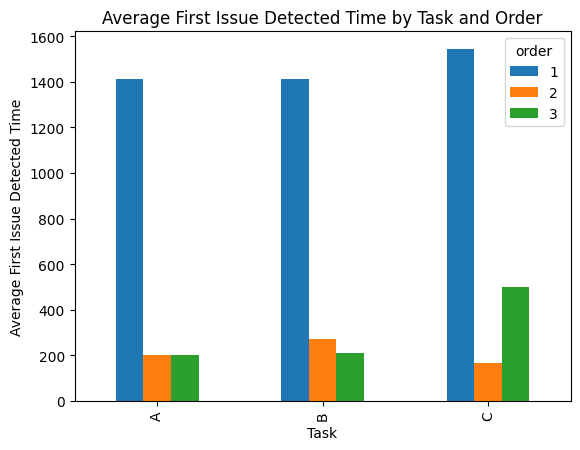

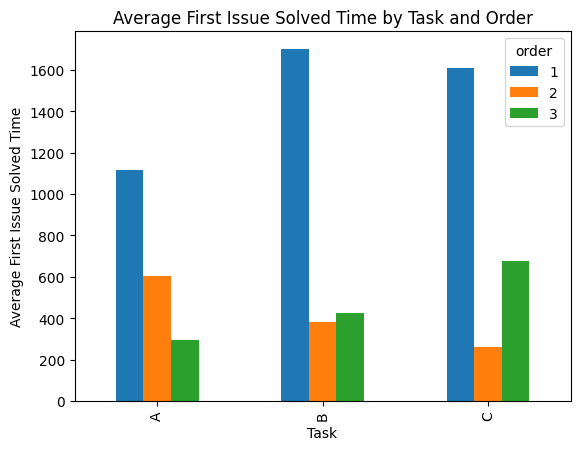

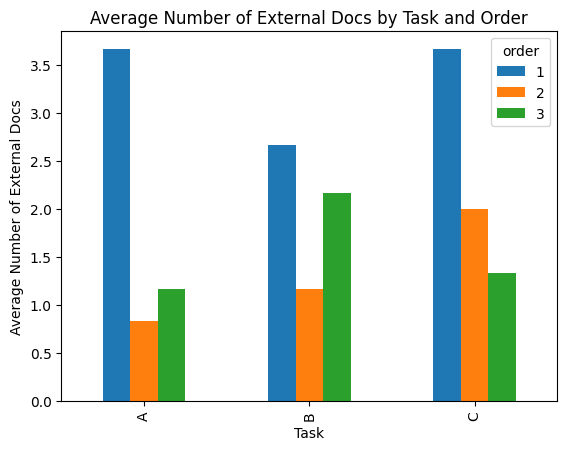

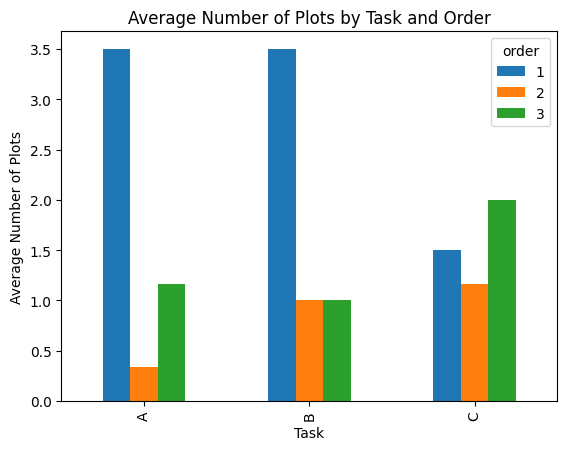

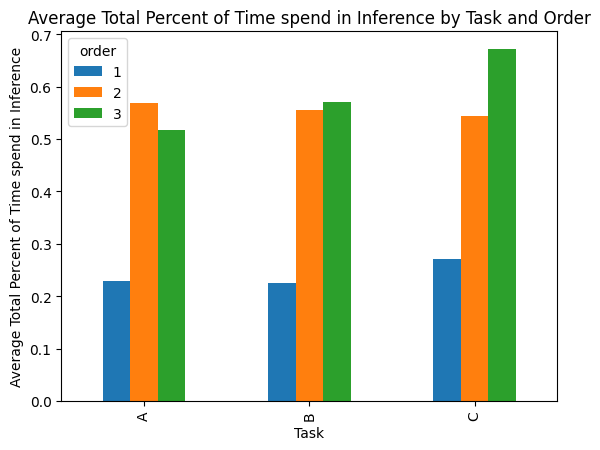

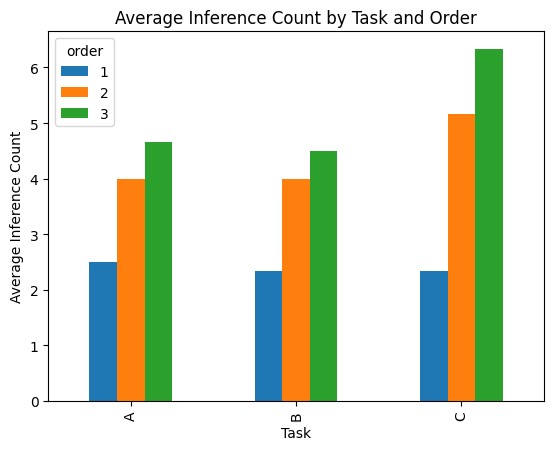

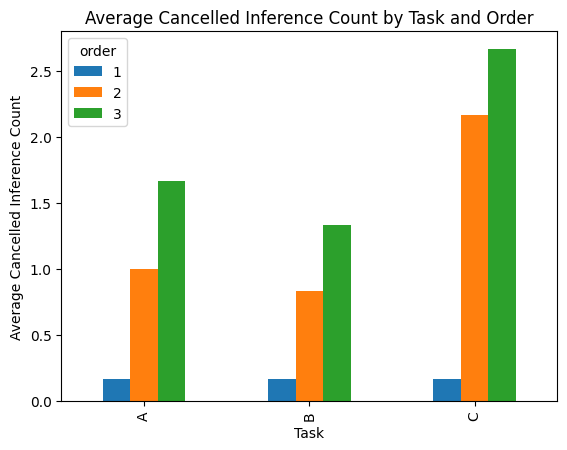

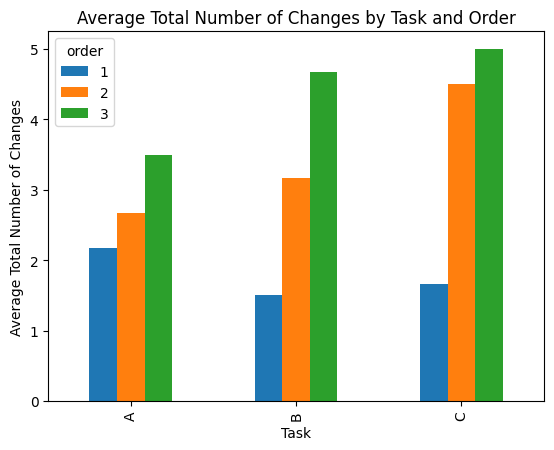

In [44]:
group_tasks_order_and_plot(df, 'Percentage of Solved Issues', 'Average Percentage of Solved Issues by Task and Order', 'Average Percentage of Solved Issues', 'Task')
group_tasks_order_and_plot(df, 'Total Task Time', 'Average Total Task Time by Task and Order', 'Average Total Task Time', 'Task')
group_tasks_order_and_plot(df, 'Fully Solved (seconds)', 'Average Fully Solved Time by Task and Order', 'Average Fully Solved Time', 'Task')
group_tasks_order_and_fillna_and_plot(df, 'Fully Solved (seconds)', 30*60, 'Average Solving Time or exceeds', 'Average Fully Solved Time', 'Task')
group_tasks_order_and_fillna_and_plot(df, 'First Issue Detected', 30*60, 'Average First Issue Detected Time by Task and Order', 'Average First Issue Detected Time', 'Task')
group_tasks_order_and_fillna_and_plot(df, 'First Issue Solved', 30*60, 'Average First Issue Solved Time by Task and Order', 'Average First Issue Solved Time', 'Task')
group_tasks_order_and_plot(df, 'Number of External Docs', 'Average Number of External Docs by Task and Order', 'Average Number of External Docs', 'Task')
group_tasks_order_and_plot(df, 'Number of Plots', 'Average Number of Plots by Task and Order', 'Average Number of Plots', 'Task')

group_tasks_order_and_plot(df, 'Total Percent of Time spend in Inference', 'Average Total Percent of Time spend in Inference by Task and Order', 'Average Total Percent of Time spend in Inference', 'Task')
group_tasks_order_and_plot(df, 'Inference Count', 'Average Inference Count by Task and Order', 'Average Inference Count', 'Task')
group_tasks_order_and_plot(df, 'Cancelled Inference Count', 'Average Cancelled Inference Count by Task and Order', 'Average Cancelled Inference Count', 'Task')
group_tasks_order_and_plot(df, 'Total Number of Changes', 'Average Total Number of Changes by Task and Order', 'Average Total Number of Changes', 'Task')